# Introduction to Julia JuMP
<img src="pics/jump.svg" alt="Jump Logo" width="500">

## Table of Contents
* [Installation](#installation)
* [Example: Master production scheduling](#MPS)
    * [Model initialization](#initialization)
    * [Input data](#data)
    * [Decisions variables](#decisionvariables)
    * [Objective function](#objective)
    * [Constraints](#constraints)
    * [Solve model](#solve)
    * [Model results](#results)
    * [Illustration](#illustration)

# Installation of Julia JuMP<a class="anchor" id="installation"></a>

Check your installed packages:


In [1]:
using Pkg;
Pkg.status()

    Status `C:\Users\Lissy\.julia\environments\v1.2\Project.toml`
  [c52e3926] Atom v0.11.0
  [336ed68f] CSV v0.5.12
  [a93c6f00] DataFrames v0.19.4
  [60bf3e95] GLPK v0.10.0
  [2e9cd046] Gurobi v0.6.0
  [7073ff75] IJulia v1.20.0
  [4076af6c] JuMP v0.19.2
  [e5e0dc1b] Juno v0.7.2
  [6405355b] Mosek v1.0.4
  [1ec41992] MosekTools v0.8.0
  [91a5bcdd] Plots v0.26.3
  [f3b207a7] StatsPlots v0.12.0
  [9a3f8284] Random 


Install ``JuMP`` if necessary which we will use to formalize optimization problems. Also install ``GLPK`` an open-source solver to solve the formailized problems and ``StatsPlots`` to visualize the results.


In [ ]:
#Pkg.add("JuMP")
#Pkg.add("GLPK");
#Pkg.add("StatsPlots");

Initialize the packages to be used in this notebook.

In [2]:
using JuMP, GLPK, StatsPlots;

# Exampe: Master production scheduling<a class="anchor" id="mps"></a>
### Decision variables:
Determine the optimal **production volume** of the products,

### Objective function:
0) **Maximize profit**: $ \qquad \max profit = \displaystyle\sum_{i=1}^I(e_i - k_i^v)\cdot X_i $



### Constraints:


1) **Capacity restriction:** $\hspace{50mm} \sum_{i=1}^I(r_{ij}\cdot X_i) \leq c_j \hspace{29mm} \forall j \in J $

2) **Upper sales limit:** $ \hspace{54mm} X_i \leq d_i \hspace{49mm} \forall i \in I $

3) **Non-negativity:** $ \hspace{57mm} X_i \geq 0 \hspace{50mm}    \forall i \in I $


* * * 


## Used symbols

### Sets

$i \in (1,..,I) \hspace{20mm}$ Products

$j \in (1,..,J) \hspace{19mm}$ Ressources




### Variables

$X_i$     $\geq0 \hspace{30mm}$ Production volumes





### Parameters 

$e_i \hspace{39mm}$   Revenue of product i 

$k_i^v \hspace{38mm}$  Variable production costs of product i

$d_i \hspace{39mm}$  Upper sales limit of product i   

$r_{ij} \hspace{38mm}$  Production coefficient of product i on ressource j 

$c_j \hspace{39mm}$  Capacity of ressource j


* * *


## Initialize the model ``m`` and set the used solver to ``GLPK``. <a class="anchor" id="initialzation"></a>

In [3]:
m = Model(with_optimizer(GLPK.Optimizer));

## Data for sets and parameters<a class="anchor" id="data"></a>

In [4]:
# sets
products =   ["Normal", "Grande"];
ressources = ["production", "paint", "assemble"];

# set length
I = length(products);
J = length(ressources);

# parameters
e  = [30,40];         # Revenue of product i 
kv = [20,25];         # Variable production costs of product i
d  = [100,100];       # Upper sales limit of product i 
c =  [2400,4000,900]; # Capacity of ressource j

#Production coefficient of product i on ressource j [products x ressources]
r  = [ 6 20  4        
      20 20  9];

## Decision variables<a class="anchor" id="decisionvariables"></a>
Initialize the decision variables, including the domain (constraint 3).

3) **Non-negativity constraint**: There can not be any negative units produced.

 $ \qquad X_i \geq 0 \qquad \qquad \qquad    \forall i \in I $

In [5]:
@variable(m, X[1:I] >= 0)

2-element Array{VariableRef,1}:
 X[1]
 X[2]

## Objective function<a class="anchor" id="objective"></a>

structure: 
``@objective(model_name?, Min/Max?, Calculation?);``

0) **Profit maximization**: The overall profit is ought to be maximize, it consists of the single profits of the products times their production volume.

$ \qquad \max db = \displaystyle\sum_{i=1}^I(e_i - k_i^v)\cdot X_i $ 

 * * *
 

In [6]:
@objective(m, Max, sum( (e[i] - kv[i]) * X[i] for i=1:I) )

10 X[1] + 15 X[2]

## Constraints<a class="anchor" id="constraints"></a>
structure: 

``@constraint(model_name?, Constraint_name[domain], (In)Equality_formulation?);``

1) **Capacity restriction**: There might be a capacity restriction on the overall time available at each production ressource. The sum of all prodcution times of all products i= 1,...,I on each ressource j is not supposed to be larger than its capacity limit $ c_j $.

$\qquad \sum_{i=1}^I(r_{ij}\cdot X_i) \leq c_j \qquad \forall j \in J $



In [7]:
@constraint(m, CapacityRestriction[j=1:J], sum(r[i,j] * X[i] for i=1:I) <= c[j] )

3-element Array{ConstraintRef{Model,C,Shape} where Shape<:AbstractShape where C,1}:
 CapacityRestriction[1] : 6 X[1] + 20 X[2] <= 2400.0 
 CapacityRestriction[2] : 20 X[1] + 20 X[2] <= 4000.0
 CapacityRestriction[3] : 4 X[1] + 9 X[2] <= 900.0   

2) **Upper sales limit**: There might be an upper limit on the sales volume based on demand. Production should not exceed this value.

 $ \qquad X_i \leq d_i \qquad \qquad \qquad \forall i \in I $


In [8]:
@constraint(m, UpperLimit[i=1:I], X[i] <= d[i])

2-element Array{ConstraintRef{Model,C,Shape} where Shape<:AbstractShape where C,1}:
 UpperLimit[1] : X[1] <= 100.0
 UpperLimit[2] : X[2] <= 100.0

Let's take a look at the whole model.

In [9]:
m

A JuMP Model
Maximization problem with:
Variables: 2
Objective function type: GenericAffExpr{Float64,VariableRef}
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 2 constraints
`GenericAffExpr{Float64,VariableRef}`-in-`MathOptInterface.LessThan{Float64}`: 5 constraints
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: GLPK
Names registered in the model: CapacityRestriction, UpperLimit, X

## Solve the model.<a class="anchor" id="solve"></a>

In [10]:
optimize!(m)

## Model results<a class="anchor" id="results"></a>

Print the objective function value.


In [11]:
println("Objective value: ", JuMP.objective_value(m))

Objective value: 1833.3333333333335


Print the production volumes.

In [12]:
JuMP.value(X[1])

100.0

In [13]:
JuMP.value(X[2])

55.55555555555556

You can also analyze the model solution status and its dual variables.

In [14]:
println("Termination status: ", JuMP.termination_status(m))
println("Primal status: ", JuMP.primal_status(m))

Termination status: OPTIMAL
Primal status: FEASIBLE_POINT


In [15]:
JuMP.has_duals(m)

true

for the capacity constraint

In [16]:
# does not reflect signs
JuMP.dual(CapacityRestriction[1]), JuMP.dual(CapacityRestriction[2]), JuMP.dual(CapacityRestriction[3])

(-0.0, -0.0, -1.6666666666666667)

In [17]:
JuMP.shadow_price(CapacityRestriction[1]), JuMP.shadow_price(CapacityRestriction[2]), JuMP.shadow_price(CapacityRestriction[3])

(0.0, 0.0, 1.6666666666666667)

for the upper sales limit

In [ ]:
JuMP.shadow_price(UpperLimit[1]), JuMP.shadow_price(UpperLimit[2])

## Create an illustration<a class="anchor" id="illustration"></a>

Combine all production volumes into a matrix

In [18]:
bardata = [JuMP.value(r[i,j]*X[i]) for j in 1:J, i in 1:I]

3×2 Array{Float64,2}:
  600.0  1111.11
 2000.0  1111.11
  400.0   500.0 

Plot the used capacity in relation to the capacity limits

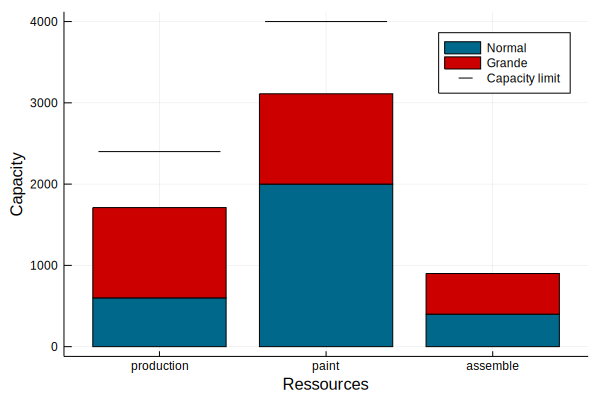

In [19]:
groupedbar(ressources, bardata, bar_position = :stack, label = products,  ylabel = "Capacity", 
           xlabel ="Ressources", colour = [:DeepSkyBlue4 :Red3])
scatter!(ressources, c, label="Capacity limit", marker=(:hline, 60))

Learn some more about plots in the visualization notebook provided on ISIS.